<b> If this tutorial has helped you in your learning. Do Apperiatiate by Upvoting. It won't going to cost you ! </b> 

This tutorial is part-2 of [Comprehensive tutorial on NLP](https://www.kaggle.com/kksienc/comprehensive-nlp-tutorial-1-ml-perspective) series. In this part we will learn about word embeddings and see how Deep learning has simplified NLP. 

Pre-requisite: Basic Deep learning understanding would be helpful though not mandatory.

<a class="kk" id="0.1"></a>
## Contents

1. [Introduction to Word Embedding](#1)
    1. [Dimensionality](#1.1) 
    1. [Padding](#1.2)
    1. [Euclidean Distance](#1.3)
    1. [Cosine Similarity](#1.4)
1. [Word Embedding Techniques](#2)
    1. [Word2Vec](#2.1)
        1. [Skip-Gram](#2.1.1)
        1. [CBOW (Continuous Bag of Words)](#2.1.2)
    1. [GloVe](#2.2) 
    1. [FastText](#2.3)
1. [Text to Numeric Convertion Using Word Vectors](#3)
    1. [Vector Averaging](#3.1)
        1. [Vector Averaging With Word2Vec](#3.1.1)
        1. [Vector Averaging With GloVe](#3.1.2)
        1. [Vector Averaging With FastText](#3.1.3) 
    1. [Embedding Matrix & Keras Embedding layer](#3.2)
        1. [Word2Vec Embedding layers](#3.2.1)
        1. [GloVe Embedding layers](#3.2.2)
        1. [FastText Embedding layers](#3.2.3)      
1. [Deep Learning models](#4)
    1. [Basic-DNN](#4.1)
    1. [CNN](#4.2)
    1. [RNN](#4.3)
    1. [Recurrent Neural Network -LSTM](#4.4)
    1. [Recurrent Neural Network – GRU](#4.5)
 

# 1. Introduction to Word Embedding  <a class="kk" id="1"></a>
[Back to Contents](#0.1)

Word Embedding is also known as Word Vectorization. It means converting word into vector. Vectors are numeric representation of a point in space. Mathematically vectors are 1D array or sequence of numbers.  


<B>Why we need Word Embedding? </B>

A problem with our previous text to numeric conversion techniques (countvectorizer & tfidf) was that, they ignore synonyms. For example, word 'measure' and ‘calculate’ were represented differently however, in most sentences they can be used interchangeably. In Word Embedding, similar words are spatially close to each other in vector space. Word Embedding is also capable of preserving semantic and syntactic similarity and relation with other words. The vector representation are such that geometric transformation adopts syntax and semantic. For instance, by adding a “female” vector to the vector "king", we obtain the vector "queen" and by adding a "plural" vector to the vector "king", we obtain "kings". 

Another problem we observe in [part-1](https://www.kaggle.com/kksienc/comprehensive-nlp-tutorial-1-ml-perspective), was production of high dimensionality sparse matrix. Word Embedding solve this also, as it produces low dimensional dense matrix.


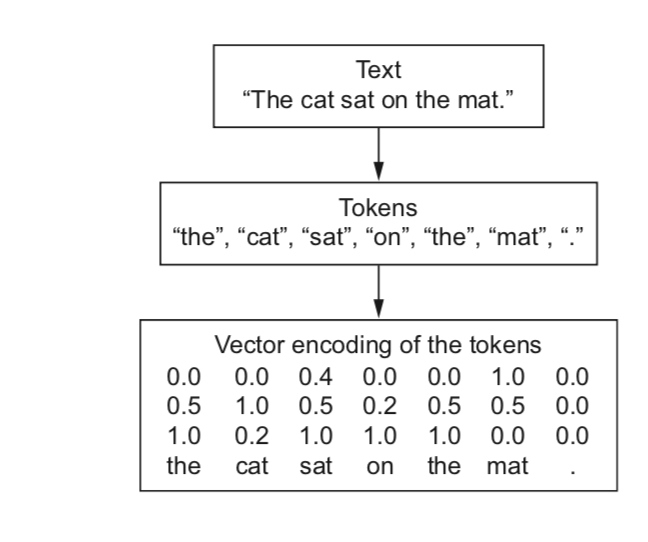

In [1]:
from IPython.display import Image
Image("/kaggle/input/images/textproc.jpg",  width=400)

Before applying Word Embedding techniques lets look into into few common NLP vocabulary terms.

## 1.1 Dimensionality  <a class="kk" id="1.1"></a>

Dimensionality refers to the length of vectors and equals to number of columns of vector representation.
For example, in the above figure each token is encoded into vector of dimesionality 3.

## 1.2 Padding <a class="kk" id="1.2"></a>

Padding is task of appending string up to given specific length with whitespaces. Padding is used to represent all records as fixed length.

## 1.3 Euclidean Distance <a class="kk" id="1.3"></a>

Euclidean distance is the shortest distance between two points in (Euclidean) space.

 

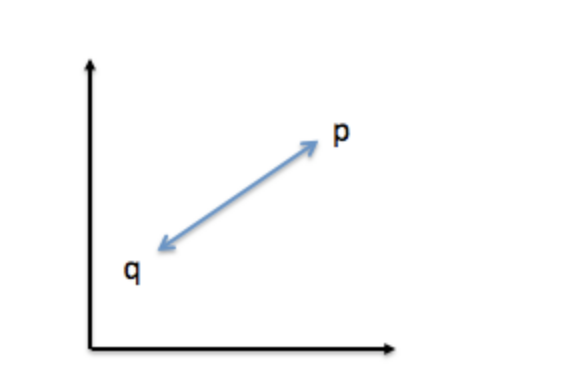

In [2]:
Image("/kaggle/input/images/eucldeandistance.png",  width=400)

## 1.4 Cosine Similarity  <a class="kk" id="1.4"></a>
Cosine similarity is a measure of similarity between two nonzero vectors of an inner product space. It measures the cosine of the angle between them. 
 

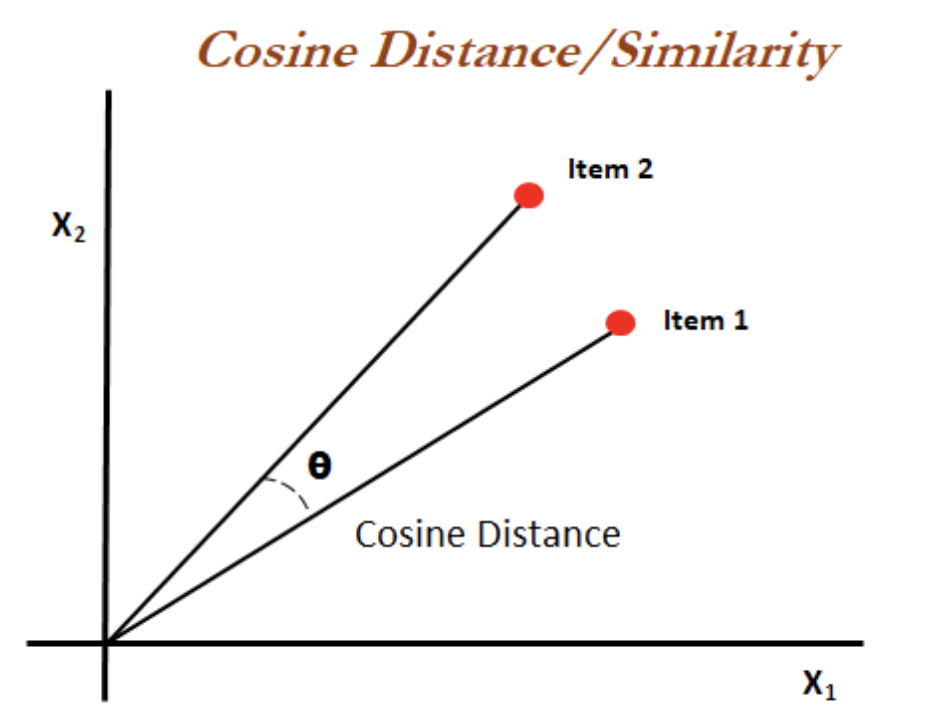

In [3]:
Image("/kaggle/input/images/cosineSimilarity.png",  width=400)

# 2. Word Embedding Techniques <a class="kk" id="2"></a>
[Back to Contents](#0.1)

Now we will dive deep into word Embedding techniques. But first let's fetch our [Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started) dataset and clean it, as we did in [part 1](https://www.kaggle.com/kksienc/comprehensive-nlp-tutorial-1-ml-perspective).

In [4]:
# Fetch & clean dataset 
!pip install pyspellchecker
from spellchecker import SpellChecker
import pandas as pd
from nltk.corpus import stopwords 
from nltk.corpus import wordnet

from nltk.stem import WordNetLemmatizer 
import nltk 
import re
import numpy as np  
import pandas as pd 
train_df = pd.read_csv("../input/nlp-getting-started/train.csv")
test_df = pd.read_csv("../input/nlp-getting-started/test.csv")


def convert_to_antonym(sentence):
    words = nltk.word_tokenize(sentence)
    new_words = []
    temp_word = ''
    for word in words:
        antonyms = []
        if word == 'not':
            temp_word = 'not_'
        elif temp_word == 'not_':
            for syn in wordnet.synsets(word):
                for s in syn.lemmas():
                    for a in s.antonyms():
                        antonyms.append(a.name())
            if len(antonyms) >= 1:
                word = antonyms[0]
            else:
                word = temp_word + word # when antonym is not found, it will
                                    # remain not_happy
            
            temp_word = ''
        if word != 'not':
            new_words.append(word)
    return ' '.join(new_words)


# def correct_spellings(text):
#     spell = SpellChecker()
#     corrected_words = []
#     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_words.append(spell.correction(word))
#         else:
#             corrected_words.append(word)
#     return " ".join(corrected_words)

        
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV }
def lemma_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word ,wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

 
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
  """
    text = text.lower() # lowercase text
    text= re.sub(r'[^\w\s#]',' ',text) #Removing every thing other than space, word and hash
    text  = re.sub(r"https?://\S+|www\.\S+", "", text )
    text= re.sub(r'[0-9]',' ',text)
    #text = correct_spellings(text)
    text = lemma_words(text)
    text = convert_to_antonym(text)
    text = re.sub(' +', ' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text    
    return text


train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

sentences= pd.DataFrame(columns=['text'])
sentences['text']= pd.concat([train_df["text"], test_df["text"]])

from collections import defaultdict
tokens_list = [row.split() for row in sentences['text']]



     |████████████████████████████████| 2.5 MB 909 kB/s 


## 2.1 Word2Vec    <a class="kk" id="2.1"></a>

 Word2Vec is group of related models that are used to produce Word Embeddings. It was created & patented by Tomas Mikolov and a group of a research team from Google in 2013. Each unique word in the corpus is assigned a corresponding vector in the space. Word2Vec relies only on local information of language hence the semantics learnt for a given word is only affected by the surrounding words. Underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning, this at times results into similar vector representation (cosine similarity) of multiple words. One more drawback of word2vec is it's unablity to take care of OutofVocabulary(OOV) word.


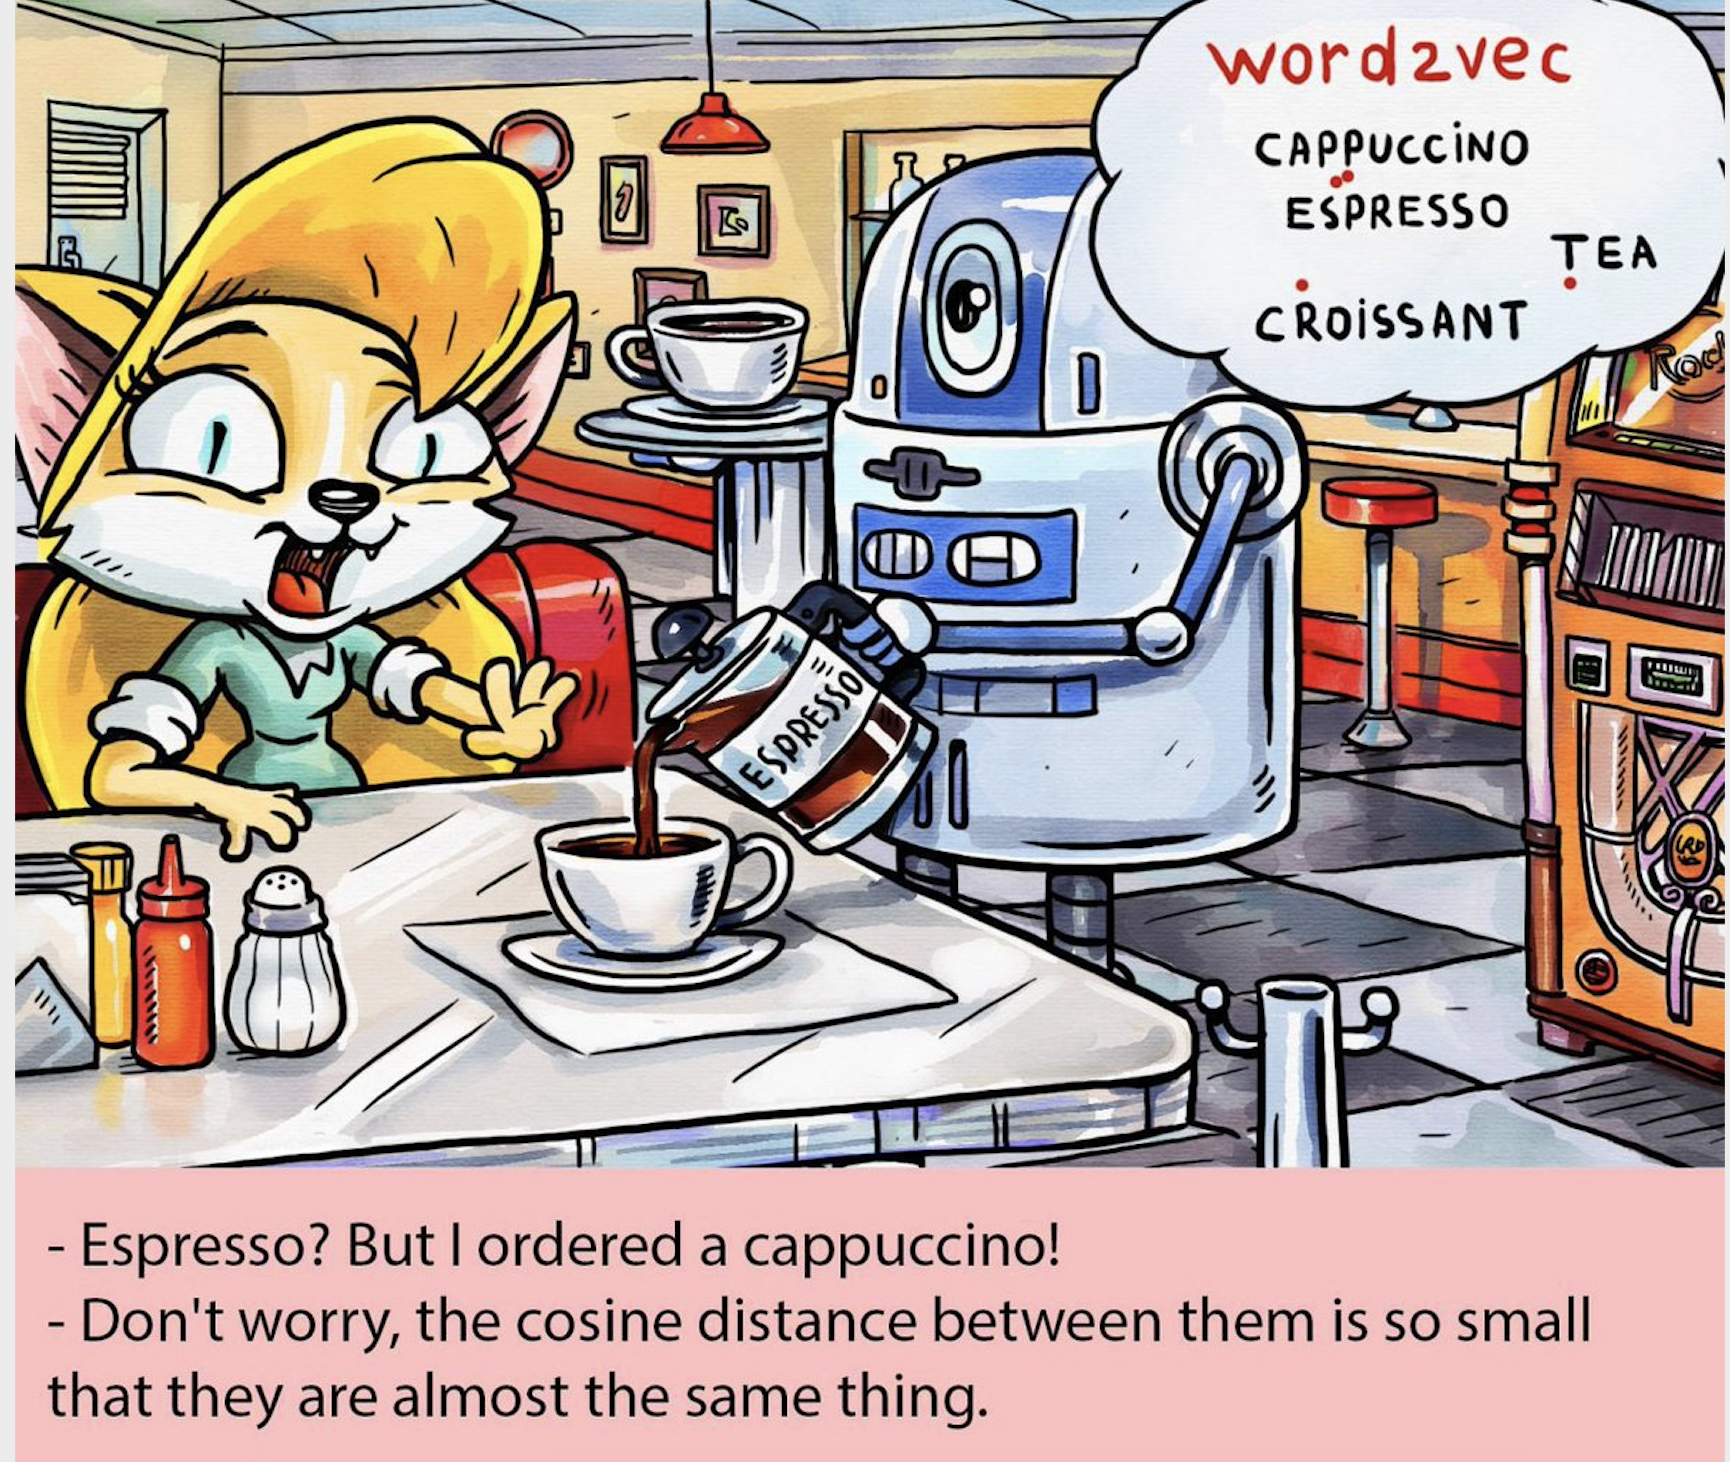

In [5]:
Image("/kaggle/input/images/word2vec.png",  width=450)


Word2Vec comes in two flavours,
 - Skip-Gram and 
 - Continuous Bag of Words (CBOW)

Underneath, Word2Vec uses neural network algorithms that can be trained on any type of sequential data. Fortunately we have libraries available that have already implemented these algorithms and we have to just call the method with proper arguments. A popular one among such libraries is <B>gensim</B>. It provides the [Word2Vec Class](https://radimrehurek.com/gensim/models/word2vec.htm) for working with a Word2Vec model.

For more details of Gensim implementation of Wrod2Vec refer their [official documentation](https://radimrehurek.com/gensim/models/word2vec.html)


###  2.1.1 Skip-Gram  <a class="kk" id="2.1.1"></a>
 
Skip-Gram is designed to predict the context from base word. From a given word, Skip-gram model tries to predict its neighbouring words.   

Skip-gram is a [(target, context), relevancy] generator. Skip-gram generator gives us pair of words and their relevance (a float value). Let's generate Word2Vec skip-gram embedding for our cleaned-up text corpus using gensim.

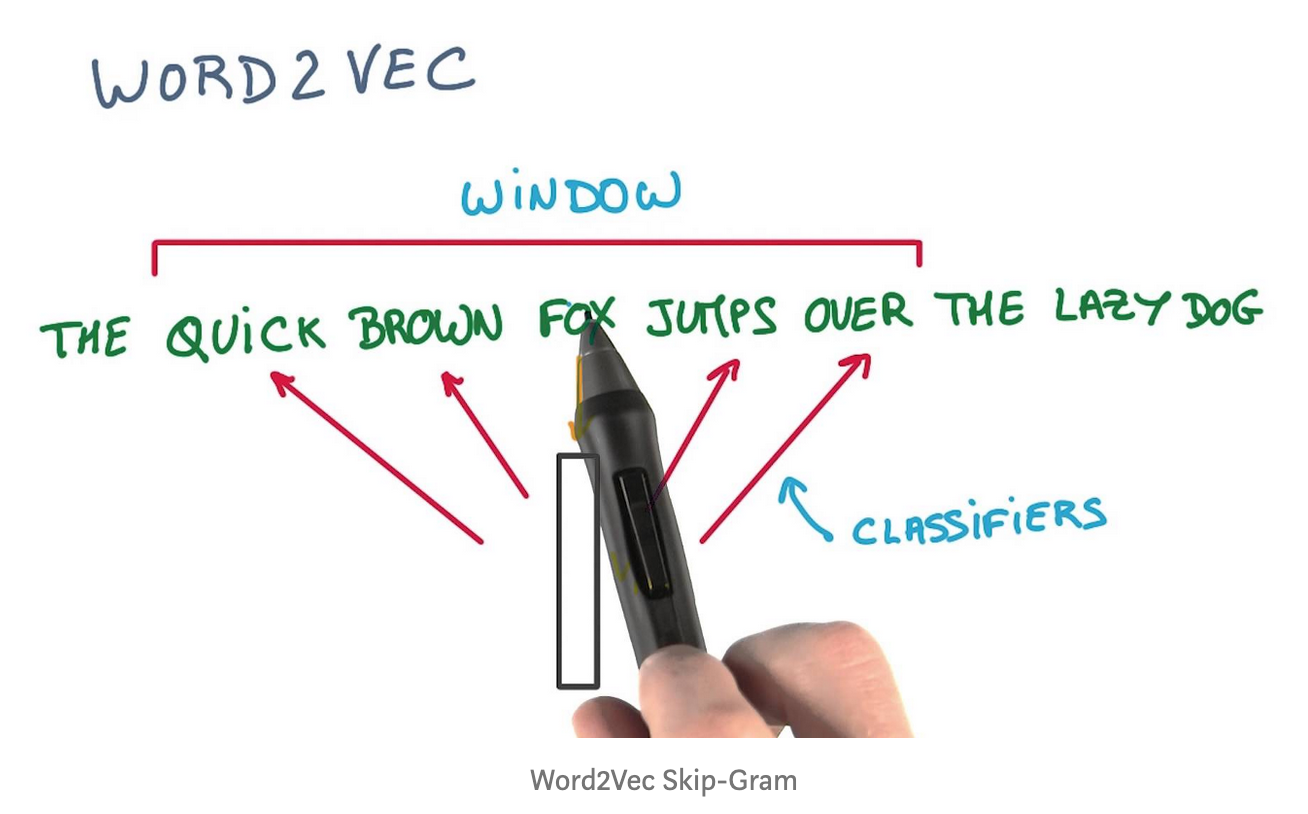

In [6]:
Image("/kaggle/input/images/skipgram.png",  width=450)

#### Building Skipgram  WordVectors using gensim

In [7]:
from gensim.models import Word2Vec
from time import time
t = time()
# initialize skipgram model
sg_model = Word2Vec(min_count=2,
                    window=2,size=300, sg = 1,
                    sample=5e-5, alpha=0.05, 
                    min_alpha=0.0005,negative=20 )

# build model vocabulary
sg_model.build_vocab(tokens_list)

# train the model
sg_model.train(tokens_list, total_examples=sg_model.corpus_count, epochs=30, report_delay=1)

print('Time to build Skip gram model vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build Skip gram model vocab: 0.33 mins


We have just build our first word-embedding model and that also with only 3 lines of code. Lets play with this model.

##### Vector representation of word

In [8]:
sg_model.wv.__getitem__('hope')

array([ 4.15468868e-03,  2.72872150e-01,  1.00247353e-01, -1.70843884e-01,
        2.10321635e-01,  3.07253450e-01, -3.65631968e-01,  2.27986127e-01,
       -1.93007872e-01,  6.90349340e-02,  5.41846491e-02,  3.24214958e-02,
        1.78974479e-01,  1.61243424e-01,  8.46912116e-02,  2.94054121e-01,
       -3.71660531e-01,  7.56814033e-02, -1.52466372e-01, -8.98855925e-03,
       -7.27324486e-02,  3.09277564e-01, -1.49917811e-01,  1.07249677e-01,
       -9.68474895e-02,  5.36530428e-02,  1.25982356e-03, -1.81601644e-01,
        2.32812986e-01,  1.27489954e-01,  7.65231699e-02,  3.45505923e-02,
        9.86319035e-02,  1.25114039e-01,  4.54832651e-02,  9.35066789e-02,
        1.56394973e-01, -3.25669438e-01, -3.40132326e-01,  3.65832001e-01,
        4.20793220e-02, -1.92663446e-01,  9.04096365e-02,  3.39820683e-01,
        2.02570453e-01,  2.29461640e-02,  1.80686802e-01, -1.60615727e-01,
        2.09157526e-01,  5.94836473e-01,  3.73277217e-01, -1.22063719e-01,
       -9.42547694e-02, -

##### Validate dimension of our word vector

In [9]:
len(sg_model.wv.__getitem__('hope'))

300

##### Measure similarity   b/w two words 

In [10]:
sg_model.wv.similarity('people','saint' )


0.23472506

In [11]:
sg_model.wv.similarity('people', 'terrorist')

0.33767268

Intrestingly, there's higher similarity b/w people & terrorists than people & saints :()


##### Fetch most similar words for any given word 

In [12]:
# top 5 similar words
sg_model.wv.most_similar('fire')[:5]

[('hallett', 0.6908873915672302),
 ('xmblq', 0.6787474751472473),
 ('knx', 0.6760497689247131),
 ('tucson', 0.675364077091217),
 ('twqvkzy', 0.6669455766677856)]

##### Fetch list of word vocabulary 

In [13]:
print(list(sg_model.wv.vocab))
 

['our', 'deed', 'be', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'u', 'all', 'forest', 'fire', 'near', 'la', 'canada', 'resident', 'ask', 'to', 'shelter', 'in', 'place', 'by', 'officer', 'no', 'other', 'evacuation', 'or', 'order', 'expect', 'people', 'receive', 'wildfires', 'california', 'just', 'get', 'send', 'photo', 'from', 'ruby', 'alaska', 'a', 'smoke', 'pour', 'into', 'school', 'rockyfire', 'update', 'hwy', 'close', 'both', 'direction', 'due', 'lake', 'county', 'cafire', 'flood', 'disaster', 'heavy', 'rain', 'cause', 'flash', 'flooding', 'street', 'colorado', 'spring', 'area', 'i', 'm', 'on', 'top', 'hill', 'and', 'can', 'see', 'wood', 'there', 's', 'an', 'emergency', 'happen', 'now', 'building', 'across', 'afraid', 'that', 'tornado', 'come', 'three', 'die', 'heat', 'wave', 'so', 'far', 'haha', 'south', 'tampa', 'hah', 'wait', 'second', 'live', 'what', 'gon', 'na', 'do', 'florida', 'day', 've', 'lose', 'count', 'bago', 'myanmar', 'we', 'arrive', 

### 2.1.2 CBOW (Continuous Bag of Words)  <a class="kk" id="2.1.2"></a>

CBOW is designed to predict the base(target) word from context. CBOW is faster to train than the skip-gram and gives slightly better accuracy for frequent words.


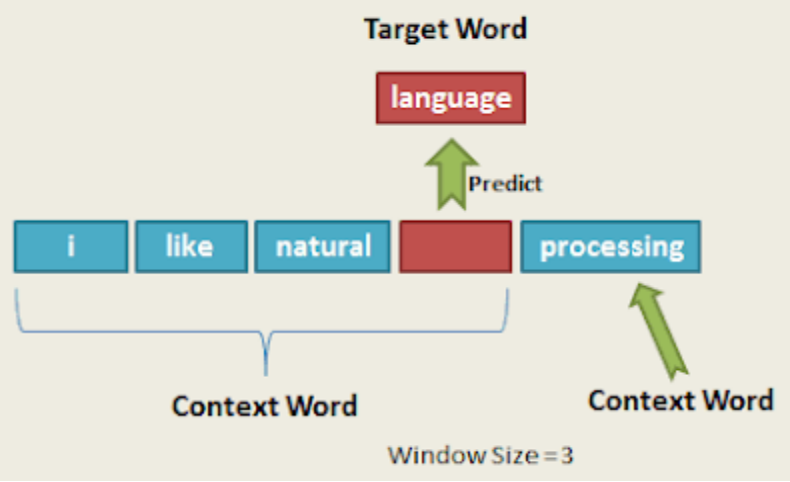

In [14]:
Image("/kaggle/input/images/cbow.png", width=450)

In [15]:
#### Building CBOW wordvectors
from gensim.models import Word2Vec
from time import time
t = time()
# initialize
cbow_model = Word2Vec(min_count=2,window=2,size=300, sg = 0,sample=5e-5, alpha=0.05, min_alpha=0.0005, 
                     negative=20 )
# build model vocabulary
cbow_model.build_vocab(tokens_list)

# train the model
cbow_model.train(tokens_list, total_examples=cbow_model.corpus_count, epochs=30, report_delay=1)

print('Time to build CBOW model vocab: {} mins'.format(round((time() - t) / 60, 2)))


Time to build CBOW model vocab: 0.17 mins


Did you notice CBOW trained faster than Skipgram ?


####  Pretrain Word2Vec

Google has made available pretrained word embedding which includes word vectors for a vocabulary of 3 million words and phrases that they have trained on roughly 100 billion words from Google News dataset using Word2Vec.

In [16]:
#fetching  pretrain wordvector
from gensim.models.keyedvectors import KeyedVectors
t = time()
pretrained_w2vec_embedding = KeyedVectors.load_word2vec_format('../input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin', binary=True)
print('Time to fetch  pretrain  Word2Vec model vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to fetch  pretrain  Word2Vec model vocab: 2.27 mins


#### vector representation of Word2Vec pretrained word 

In [17]:
pretrained_w2vec_embedding['people']

array([ 0.26367188, -0.01916504,  0.02893066,  0.234375  , -0.00787354,
        0.01635742, -0.11279297,  0.06640625,  0.0015564 , -0.0402832 ,
       -0.0246582 , -0.11523438, -0.05615234, -0.05126953, -0.11621094,
        0.05053711, -0.09277344,  0.16113281, -0.10498047,  0.07958984,
       -0.125     , -0.04711914,  0.14257812, -0.17578125,  0.00460815,
       -0.15136719, -0.11621094,  0.07470703,  0.05932617, -0.21289062,
       -0.08544922,  0.21582031, -0.28515625,  0.08349609, -0.02124023,
        0.1171875 , -0.09814453, -0.02185059, -0.17089844,  0.21972656,
        0.01916504, -0.06982422,  0.11474609, -0.08300781,  0.08398438,
       -0.01098633, -0.13476562, -0.09960938, -0.03637695, -0.09863281,
        0.125     , -0.01391602,  0.21972656,  0.0390625 ,  0.05688477,
       -0.1484375 , -0.22070312,  0.00640869, -0.10205078, -0.04589844,
        0.08984375,  0.13378906, -0.14648438, -0.03515625,  0.12890625,
        0.01391602, -0.08642578,  0.29101562,  0.06982422, -0.01

In [18]:
# shape of pretrain w2vec embedding
pretrained_w2vec_embedding.vectors.shape

(3000000, 300)

In [19]:
#del pretrained_w2vec_embedding

## 2.2 GloVe  <a class="kk" id="2.2"></a>

[GloVe](https://nlp.stanford.edu/pubs/glove.pdf) stands for "Global Vectors". It is a Word Embedding [project](https://nlp.stanford.edu/projects/glove/)  written in C language and developed by Stanford university researchers in 2014. Glove embedding technique is based on 
firstly, construction of a co-occurrence matrix from a training corpus and then 
secondly, factorization of co-occurrence matrix in order to yield word vector.

Unlike word2vec, which captures only local statistics of token, Glove captures both global statistics and local statistics of a text tokens. GloVe embeddings relate to the probabilities that two words appear together. [glove_python](https://github.com/maciejkula/glove-python) library provides glove implementation.

For more details of GloVe implementation of  glove_python refer their [official documentation](https://pypi.org/project/glove/)


In [20]:
!pip install glove_python

     |████████████████████████████████| 263 kB 791 kB/s 
  Created wheel for glove-python: filename=glove_python-0.1.0-cp36-cp36m-linux_x86_64.whl size=745357 sha256=69d882d64a29e98c326c9036ed3507b8032a3936647b127b4b94fdac636b7cc5
  Stored in directory: /root/.cache/pip/wheels/c2/34/66/a3adc1e41bd5cfe3aa8f75e34b42ca207f8b6e8171b9a4fd61
Successfully built glove-python


In [21]:
#importing the glove library
from glove import Corpus, Glove

# creating a corpus object
corpus = Corpus() 

#training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(tokens_list, window=3)

#creating a Glove object which will use the matrix created in the above lines to create embeddings
#we can set the learning rate as glove uses Gradient Descent
glove = Glove(no_components=300, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


#####  Displaying Glove WordVector of a word 

In [22]:
glove.word_vectors[glove.dictionary['people']]

array([ 8.38008664e-02,  6.49120900e-02,  1.31741564e-01,  4.71414893e-02,
        5.14144656e-02,  4.91617639e-02, -3.70615269e-03, -2.04328820e-02,
       -2.84475707e-02, -4.15201803e-02,  5.26445647e-02,  1.18198124e-02,
       -1.90527806e-02,  1.40481239e-01, -4.09013983e-02, -8.34276073e-02,
       -6.41632318e-02,  6.61813878e-02,  8.04609027e-02, -4.07414200e-02,
       -1.95202047e-02,  9.58225966e-02, -1.50178364e-01, -8.31161016e-02,
       -2.48764180e-02,  1.49150637e-02, -5.75320937e-03,  1.10646743e-01,
       -3.53710007e-02, -8.11407405e-02,  5.52017816e-03, -1.16894831e-01,
        7.61145564e-02,  8.46721415e-02, -1.22085324e-01,  1.26755437e-01,
       -9.39603633e-02, -1.06932066e-01,  9.51617859e-03,  7.63859628e-02,
       -5.59144359e-02, -1.56406156e-02, -8.30635525e-02,  2.82256918e-02,
       -7.06176246e-02, -7.93222840e-02,  1.97762367e-02,  8.49384336e-04,
       -5.01374013e-02,  1.14213937e-01, -4.35787671e-02,  7.61651881e-02,
       -1.36040305e-01,  

#### Pretrain Glove

Glove developers have also made available pre-computed embeddings for millions of English tokens, obtained from training Wikipedia data and Common crawl data.

<B>Due to notebook memory constrains, I have commented out Pretrained Glove and Pretrained Fast-text.However, there usage is similar to pre-trained Word2Vec. You can uncomment and run on separate notebook </B>

In [23]:
# # Fetch pretrain glove word vectors 
# import numpy as np 
# pretrained_glove_embedding={}
# with open('../input/nlpword2vecembeddingspretrained/glove.6B.300d.txt','r') as f:
#     for line in f:
#         values=line.split()
#         word=values[0]
#         vectors=np.asarray(values[1:],'float32')
#         pretrained_glove_embedding[word]=vectors
# f.close()

#####   Glove pretrained WordVector of a word 

In [24]:
#pretrained_glove_embedding['hello']


In [25]:
# no of  word in pretrained glove embedding
#len(pretrained_glove_embedding)

In [26]:
#del pretrained_glove_embedding

## 2.3. Fast-Text <a class="kk" id="2.3"></a>

[FastText](https://fasttext.cc/) is a library for learning of word embeddings and text classification. The Facebook Research Team created fastText in Nov 2015. Fast-Text is an extension of word2vec library. It builds on Word2Vec by learning vector representations for each word and the n-grams found within each word. FastText assumes a word to be formed by a n-grams of character. For example, sunny is composed of [sun, sunn,sunny],[sunny,unny,nny]... etc, where n could range from 1 to the length of the word. The values of the representations are then averaged into one vector at each training step. While this adds a lot of additional computation to training it enables word embeddings to encode sub-word information. Thus even for previously unseen words, typo errors, and OOV (Out Of Vocabulary) words the model can make an educated guess towards its meaning.Obvious trade off is processing time. Gensim provides the [FastText implementation](https://radimrehurek.com/gensim/models/fasttext.html).

For more details of FastText implementation of  Gensim refer their [official documentation](https://radimrehurek.com/gensim/models/fasttext.html)



In [27]:
# dimension =300
# from gensim.models import FastText
# fasttext_model = FastText(tokens_list, size=dimension, window=5, min_count=5, workers=4, sg=1)


#####  Displaying FastText WordVector of given word 

In [28]:
# fasttext_model.wv.__getitem__('people')

In [29]:
# # fasttext word similarity measure
# fasttext_model.wv.similarity('evacuation','shelter' )

In [30]:
# # most similar words
# fasttext_model.wv.most_similar('fire')[:5]

##### PreTrained Fasttext

FastText developers have also made available pre-computed embeddings for millions of english tokens, obtained from training Wikipedia data and common crawl data. 

Disclaimer: Loading the fastText pretrain will consume some serious memory.

As mention earlier, due to notebook memory constrains, I have commented out Pretrained-Glove and Pretrained-Fasttext here.The usage is quite similar to pre-trained Word2Vec. 

In [31]:
# def get_coefs(word, *arr): 
#     return word, np.asarray(arr, dtype='float32')

# EMBEDDING_FILE = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
# pretrained_fasttext_embedding = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in (open(EMBEDDING_FILE)))

In [32]:
## no of words in pretrained fasttext embedding
#len(pretrained_fasttext_embedding)

#####  Displaying FastText pretrained WordVector of a word 

In [33]:
#pretrained_fasttext_embedding['fire']

In [34]:
#len(pretrained_fasttext_embedding['fire'])

# 3. Text to Numeric Convertion Using Word Vectors <a class="kk" id="3"></a>
[Back to Contents](#0.1)

We learned about word embedding techniques and created word vectors for our corpus.  Now we will convert our textual data into numerical using these word vectors. I will explain about two popular texts to numerical conversion techniques using word vectors, 

1. Vector Averaging  
1. Embedding Matrix and Keras Embedding layer


## 3.1 Vector Averaging  <a class="kk" id="3.1"></a>
In Vector Averaging approach we average all word embeddings (of words) in the text. Final length remains equal to word vector dimension. This is go to technique when we are planning to use machine learning models such a logistic regression, naïve-bayes, svm etc.  
 

### Vector Averaging With Word2Vec <a class="kk" id="3.1.1"></a>

In [35]:
# functions for Vector Averaging with word2Vec
import numpy as np
def w2v_embeddings(text,w2v_model,dimension):
    if len(text) < 1:
        return np.zeros(dimension)
    else:
        vectorized = [w2v_model.wv[word] if word in w2v_model.wv else np.random.rand(dimension) for word in text] 
    
    sum = np.sum(vectorized,axis=0)
    ## return the average
    return sum/len(vectorized)     

def get_w2v_embeddings(text,w2v_model,dimension):
        embeddings = text.apply(lambda x: w2v_embeddings(x, w2v_model,dimension))
        return list(embeddings)

#### SkipGram Model

In [36]:
# Text to Numeric Vector Averaging using sgmodel 
train_embeddings_sg_model  = get_w2v_embeddings(train_df['text'],sg_model,dimension=300)
 

In [37]:
# Validate train set size
len(train_embeddings_sg_model)

7613

In [38]:
# validate dimension
len(train_embeddings_sg_model[0])

300

#### CBOW model

In [39]:
# Text to numeric Vector Averaging using cbow model
train_embeddings_cbow_model_  = get_w2v_embeddings(train_df['text'],cbow_model,dimension=300)

### Vector Averaging With Glove <a class="kk" id="3.1.2"></a>

In [40]:
## functions  for Vector Averaging with GloVe
import numpy as np
def glove_embeddings(text, glove_model, dim ):
    dic=glove_model.dictionary
    if len(text) < 1:
        return np.zeros(dim)
    else:
        vectorized = [glove_model.word_vectors[dic[word]] if word in dic else np.random.rand(dim) for word in text]  
    sum = np.sum(vectorized,axis=0)
    ## return the average
    return sum/len(vectorized)     

def get_glove_embeddings(text,glove_model,dimension):
        embeddings = text.apply(lambda x: glove_embeddings(x,glove_model, dimension))
        return list(embeddings)


In [41]:
# Text to numeric Vector Averaging using glove
import numpy as np
train_embeddings_glove = get_glove_embeddings(train_df['text'],glove,dimension=300)
test_embeddings_glove = get_glove_embeddings(test_df['text'],glove,dimension=300)

### Vector Averaging With Fasttext  <a class="kk" id="3.1.3"></a>

As Fastext is an extension of word2vec hence the same averaging function of w2vec i.e.`get_ w2v_embeddings` will work for fasttext model too. 

In [42]:
# ## Text to numeric using Averaging with Fasttext
# import numpy as np
# fasttext_train_embeddings = w2v_embeddings(train_df['text'], fasttext_model,dimension=300)
# fasttext_test_embeddings = w2v_embeddings(test_df['text'],  fasttext_model,dimension=300)

#### Vector Averaging With pretrained Embeddings

 

In [43]:
def pretrained_embeddings(text,model,dimension):
    if len(text) < 1:
        return np.zeros(dimension)
    else:
        vectorized = [model[word] if word in model else np.random.rand(dimension) for word in text] 
    
    sum = np.sum(vectorized,axis=0)
    ## return the average
    return sum/len(vectorized)     

def get_pretrained_embeddings(text,model,dimension):
        embeddings = text.apply(lambda x: pretrained_embeddings(x, model,dimension))
        return list(embeddings)

In [44]:
# uncomment section in below code in order to perfrom vector averaging using pretrained word embeeding

#Text to numeric Vector Averaging  using  pretrianed word2vec
train_embeddings_w2vec_pretrained_  = get_pretrained_embeddings(train_df['text'],pretrained_w2vec_embedding,dimension=300)

## Text to numeric Vector Averaging  using  pretrianed glove
# train_embeddings_glove_pretrained_  = get_pretrained_embeddings(train_df['text'],pretrained_glove_embedding,dimension=300)

## Text to numeric Vector Averaging  using  pretrianed fasttext
# train_embeddings_fasttext_pretrained_  = get_pretrained_embeddings(train_df['text'],pretrained_fasttext_embedding,dimension=300)



## 3.2 Embedded Matrix & Keras Embedding layer <a class="kk" id="3.2"></a>

Averaging is preferred choice when we intend to use Machine Learning models such as lr, svm, gbm etc. but our purpose here is to utilise Deep-learning algorithms. Deep Learning is a layer bases learning where each layer passes its learning to the next layer.   Few libraries have implement deep learning algorithms. A popular one among them is Keras. We will use Keras for our deep learning modelling purpose.

For text processing Keras offers an embedding layer. This is the first layer of deep learning algorithm. Weights of the Embedding layer are of the shape (vocabulary_size, embedding_dimension), this weight matrix is also called as Embedding matrix. We will first generate this embedding matrix from our word vectors and then initialize Keras embedding layer for each of our word embeddings. 

Moreover, Keras has built-in utilities for doing tokenization and encoding of text. We will use these utilities as they take care of a number of important features such as stripping special characters from strings, padding, fetching N most common words in dataset etc.

In [45]:
# using keras built in utilities
# tokenizing using keras  tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.layers import Embedding
tokenizer_obj=Tokenizer()
# to builds the word index
tokenizer_obj.fit_on_texts(tokens_list)
# to turns strings into lists of integer indices.
sequences=tokenizer_obj.texts_to_sequences(tokens_list)
# defining maximum length of sequence 
MAX_LEN= 50
# pad_sequences is used to ensure that all sequences in a list have the same length
tweet_pad= pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

# segregating text & train from corpu
x_train = tweet_pad[:7613]
x_test = tweet_pad[7613:]

targets =  [target for target in train_df['target']]

# set of all word and their sequence no
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))
vocab_size = len(word_index)+1


Using TensorFlow backend.


Number of unique words: 26515


In [46]:
# function to generate embeeding layer weights i.e. embeeding_matrix


def generate_word2vec_embeeding_matrix(word_vector_model, dimension, vocab_size= vocab_size, word_index =word_index):
    embedding_matrix=np.zeros((vocab_size,dimension))
    for word,i in tqdm(word_index.items()):
        if i > vocab_size:
            continue
        if word in word_vector_model.wv:  
            emb_vec=word_vector_model.wv.__getitem__(word)
            embedding_matrix[i]=emb_vec
    return embedding_matrix

def generate_pretrained_embeeding_matrix(word_vector_model, dimension, vocab_size= vocab_size, word_index =word_index):
    embedding_matrix=np.zeros((vocab_size,dimension))
    for word,i in tqdm(word_index.items()):
        if i > vocab_size:
            continue
        if word in word_vector_model:  
            emb_vec=word_vector_model[word]
            embedding_matrix[i]=emb_vec
    return embedding_matrix



Lets create Keras embedding layers for our word embeddings. As we have created 4 trained word embedding model (skipgram, cbow, glove and fasttext) and 3 pretrained model (one each for word2vec, glove and fasttext) for all these seven we will create a Keras embedding layer.

### Word2Vec Embedding layers  <a class="kk" id="3.2.1"></a>

##### Trained skipgram

In [47]:
from keras.layers import Embedding

embedding_matrix_sg_trained = generate_word2vec_embeeding_matrix(sg_model, dimension = 300)

embedding_layer_sg_trained = Embedding(vocab_size, output_dim= 300, weights=[embedding_matrix_sg_trained], 
                                     input_length=MAX_LEN, trainable=False)

100%|██████████| 26515/26515 [00:00<00:00, 388417.09it/s]


##### Pre-Trained  Word2Vec

In [48]:
# pre trainde word2vec  
embedding_matrix_w2v_pretrained = generate_pretrained_embeeding_matrix(pretrained_w2vec_embedding, dimension =300)    

embedding_layer_w2v_pretrained = Embedding(vocab_size, output_dim= 300, weights=[embedding_matrix_w2v_pretrained], 
                                     input_length=MAX_LEN, trainable=False)

100%|██████████| 26515/26515 [00:00<00:00, 106238.52it/s]


##### Trained  CBOW

In [49]:
embedding_matrix_cbow_trained = generate_word2vec_embeeding_matrix(cbow_model, dimension = 300)

embedding_layer_cbow_trained = Embedding(vocab_size, output_dim= 300, weights=[embedding_matrix_cbow_trained], 
                                     input_length=MAX_LEN, trainable=False)

100%|██████████| 26515/26515 [00:00<00:00, 378382.69it/s]


### GloVe Embedding Layers   <a class="kk" id="3.2.2"></a>

##### Trained Glove

In [50]:
import numpy as np
embedding_matrix_glove_trained=np.zeros((vocab_size,300))
for word,i in tqdm(word_index.items()):
    if i > vocab_size:
        continue
    
    emb_vec=glove.word_vectors[glove.dictionary[word]]
    if emb_vec is not None:
        embedding_matrix_glove_trained[i]=emb_vec

100%|██████████| 26515/26515 [00:00<00:00, 179790.56it/s]


In [51]:
embedding_layer_glove_trained = Embedding(vocab_size, 300 , weights=[embedding_matrix_glove_trained], 
                                     input_length=MAX_LEN, trainable=False)

##### PreTrained Glove

In [52]:
# embedding_matrix_glove_pretrained = generate_pretrained_embeeding_matrix(pretrained_glove_embedding, dimension =300)    

# embedding_layer_glove_pretrained = Embedding(vocab_size, output_dim= 300, weights=[embedding_matrix_glove_pretrained], 
#                                      input_length=MAX_LEN, trainable=False)

### Fasttext  Embedding layers  <a class="kk" id="3.2.3"></a>

##### Trained FastText

In [53]:
 
# embedding_matrix_fasttext_trained = generate_word2vec_embeeding_matrix(fasttext_model, dimension =300)    

# embedding_layer_fasttext_trained = Embedding(vocab_size, output_dim= 300, weights=[embedding_matrix_fasttext_trained], 
#                                      input_length=MAX_LEN, trainable=False)

##### Pre-Trained FastText

In [54]:
# embedding_matrix_fasttext_pretrained = generate_pretrained_embeeding_matrix(pretrained_fasttext_embedding, dimension =300)    

# embedding_layer_fasttext_pretrained = Embedding(vocab_size, output_dim= 300, weights=[embedding_matrix_fasttext_pretrained], 
#                                      input_length=MAX_LEN, trainable=False)

## 4. Deep Learning Models <a class="kk" id="4"></a>
[Back to Contents](#0.1)

 We have initialized Keras embedding layer for our various word embedding models. Now it’s time to train using deep learning models. I will demonstrate how to train for glove pertained layer. You can test with other six embedding layer also (by just reassigning embedding_layer). One point you will notice that pretrained embedding layers performs much better than their trained counter parts. Again the purpose here is to depict basic Deep Learning model performance and not to obtain high score. 

In [55]:
# Declare embeeding layer of your choics 
embedding_layer = embedding_layer_sg_trained

# try with other embedding layes too
#embedding_layer_glove_pretrained
# embedding_layer_fasttext_pretrained
# embedding_layer_fasttext_trained
# embedding_layer_cbow_trained
# embedding_layer_sg_trained
# embedding_layer_w2vec_pretrained
# embedding_layer_glove_trained

In [56]:
import keras
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=5),
    
]

### 4.1 Basic DNN <a class="kk" id="4.1"></a>


In [57]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
dnn_model = Sequential()
dnn_model.add(embedding_layer)
dnn_model.add(Flatten())
dnn_model.add(Dense(1, activation='sigmoid'))

dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

dnn_model.summary()

history = dnn_model.fit(x_train,  y = targets,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2, callbacks= my_callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           7954800   
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15001     
Total params: 7,969,801
Trainable params: 15,001
Non-trainable params: 7,954,800
_________________________________________________________________
Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 1s 134us/step - loss: 0.5366 - acc: 0.7437 - val_loss: 0.4808 - val_acc: 0.7735
Epoch 2/10
6090/6090 [==============================] - 0s 76us/step - loss: 0.4474 - acc: 0.8016 - val_loss: 0.4770 - val_acc: 0.7715
Epoch 3/10
6090/6090 [============================

###  4.2 CNN <a class="kk" id="4.2"></a>

In [58]:
#CNN is suitable for image processing
# import keras
# cnn_model = Sequential()
# # note : below we add embedding layer
# cnn_model.add(embedding_layer)
# cnn_model.add(keras.layers.Dropout(0.2))
# cnn_model.add(keras.layers.Conv1D(3,3, padding='valid',activation='relu', strides=1))
# cnn_model.add(keras.layers.GlobalMaxPooling1D())
# cnn_model.add(keras.layers.Dense(20))
# cnn_model.add(keras.layers.Dropout(0.2))
# cnn_model.add(keras.layers.Activation('relu'))
# cnn_model.add(keras.layers.Dense(1))
# cnn_model.add(keras.layers.Activation('sigmoid'))

# # Get model summary
# cnn_model.summary()
# cnn_model.compile(optimizer='rmsprop',
#               loss='binary_crossentropy',
#               metrics=['acc'])

# # compile the model
# history = cnn_model.fit(x_train,  y = targets,
#                     epochs=10,
#                     batch_size=32,
#                     validation_split=0.2)

### 4.3 RNN <a class="kk" id="4.3"></a>

In [59]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN
rnn_model = Sequential()
# note : below we add embedding layer
rnn_model.add(embedding_layer)
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = rnn_model.fit(x_train, y = targets,epochs=10, batch_size=32,validation_split=0.2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 4s 594us/step - loss: 0.6445 - acc: 0.6319 - val_loss: 0.5807 - val_acc: 0.7393
Epoch 2/10
6090/6090 [==============================] - 3s 456us/step - loss: 0.5687 - acc: 0.7346 - val_loss: 0.5732 - val_acc: 0.7282
Epoch 3/10
6090/6090 [==============================] - 3s 458us/step - loss: 0.5390 - acc: 0.7578 - val_loss: 0.5166 - val_acc: 0.7597
Epoch 4/10
6090/6090 [==============================] - 3s 462us/step - loss: 0.5474 - acc: 0.7532 - val_loss: 0.5081 - val_acc: 0.7794
Epoch 5/10
6090/6090 [==============================] - 3s 461us/step - loss: 0.5415 - acc: 0.7632 - val_loss: 0.5853 - val_acc: 0.7380
Epoch 6/10
6090/6090 [==============================] - 3s 454us/step - loss: 0.5537 - acc: 0.7594 - val_loss: 0.5281 - val_acc: 0.7873
Epoch 7/10
6090/6090 [==============================] - 3s 497us/step - loss: 0.6043 - acc: 0.6964 - val_loss: 0.6247 - val_acc: 0.6612


### 4.4  Recurrent Neural Network -LSTM <a class="kk" id="4.4"></a>

In [60]:
from keras.layers import LSTM
lstm_model = Sequential()
# note : below we add embedding layer
lstm_model.add(embedding_layer)
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = lstm_model.fit(x_train, y = targets,epochs=10, batch_size=32,validation_split=0.2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 6s 980us/step - loss: 0.5577 - acc: 0.7358 - val_loss: 0.5274 - val_acc: 0.7511
Epoch 2/10
6090/6090 [==============================] - 5s 865us/step - loss: 0.4902 - acc: 0.7841 - val_loss: 0.4816 - val_acc: 0.7886
Epoch 3/10
6090/6090 [==============================] - 5s 879us/step - loss: 0.4684 - acc: 0.7936 - val_loss: 0.4758 - val_acc: 0.7774
Epoch 4/10
6090/6090 [==============================] - 6s 942us/step - loss: 0.4587 - acc: 0.7964 - val_loss: 0.5767 - val_acc: 0.7420
Epoch 5/10
6090/6090 [==============================] - 6s 920us/step - loss: 0.4471 - acc: 0.8041 - val_loss: 0.4482 - val_acc: 0.7945
Epoch 6/10
6090/6090 [==============================] - 6s 991us/step - loss: 0.4365 - acc: 0.8084 - val_loss: 0.4727 - val_acc: 0.7800
Epoch 7/10
6090/6090 [==============================] - 5s 900us/step - loss: 0.4329 - acc: 0.8054 - val_loss: 0.4583 - val_acc: 0.7978


### 4.5 Recurrent Neural Network – GRU <a class="kk" id="4.5"></a>

In [61]:
from keras.layers import GRU
gru_model = Sequential()
# note : below we add embedding layer
gru_model.add(embedding_layer)
gru_model.add(GRU(32))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = gru_model.fit(x_train, y = targets,epochs=10, batch_size=32,validation_split=0.2)

Train on 6090 samples, validate on 1523 samples
Epoch 1/10
6090/6090 [==============================] - 8s 1ms/step - loss: 0.6817 - acc: 0.5791 - val_loss: 0.6907 - val_acc: 0.5345
Epoch 2/10
6090/6090 [==============================] - 7s 1ms/step - loss: 0.6298 - acc: 0.6432 - val_loss: 0.5574 - val_acc: 0.7663
Epoch 3/10
6090/6090 [==============================] - 7s 1ms/step - loss: 0.5219 - acc: 0.7695 - val_loss: 0.5081 - val_acc: 0.7814
Epoch 4/10
6090/6090 [==============================] - 7s 1ms/step - loss: 0.4934 - acc: 0.7818 - val_loss: 0.4747 - val_acc: 0.7978
Epoch 5/10
6090/6090 [==============================] - 7s 1ms/step - loss: 0.4734 - acc: 0.7972 - val_loss: 0.4974 - val_acc: 0.7682
Epoch 6/10
6090/6090 [==============================] - 7s 1ms/step - loss: 0.4623 - acc: 0.7990 - val_loss: 0.5622 - val_acc: 0.7590
Epoch 7/10
6090/6090 [==============================] - 7s 1ms/step - loss: 0.4518 - acc: 0.8057 - val_loss: 0.4760 - val_acc: 0.7859
Epoch 8/10
609

###  Target Prediction  

In [62]:
# lets predict target values for test set
model =  dnn_model
raw_preds = model.predict(x_test)
preds = raw_preds.round().astype(int)
preds

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

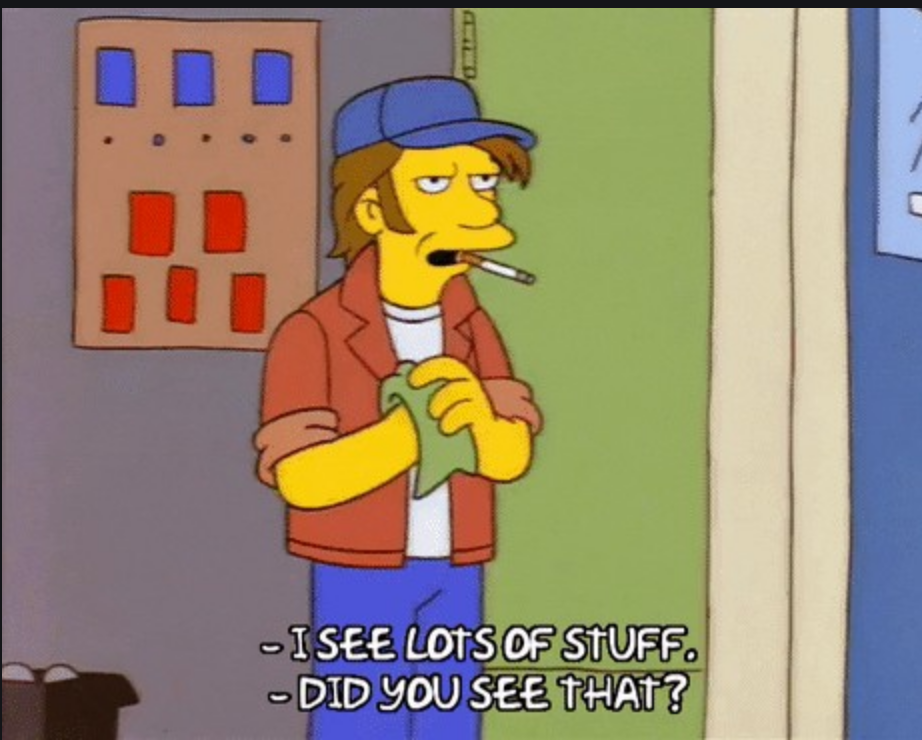

In [63]:
Image("/kaggle/input/images/too much.png",  width=450)

 


Thanks for reading ! 

If you like this kernel, <b>  Do Upvote</b>!!! Its at the top right near Copy&Edit and will not cost you:)


In the next [part-3](https://www.kaggle.com/kksienc/comprehensive-nlp-tutorial-3-bert-others) we will read about state-of-the-art 'BERT Embedding'.





## References
- Deep Learning with Python by FRANÇOIS CHOLLET  http://faculty.neu.edu.cn/yury/AAI/Textbook/Deep%20Learning%20with%20Python.pdf
- https://en.wikipedia.org/
- https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/eb9cd609-e44a-40a2-9c3a-f16fc4f5289a.xhtml
- https://www.kdnuggets.com/2018/04/implementing-deep-learning-methods-feature-engineering-text-data-skip-gram.html
- https://www.kaggle.com/c/quora-question-pairs/discussion/31257#177483
- https://www.kaggle.com/slatawa/simple-implementation-of-word2vec
- https://becominghuman.ai/how-does-word2vecs-skip-gram-work-f92e0525def4
- https://www.thinkinfi.com/2019/06/single-word-cbow.html(image)
- https://www.kaggle.com/rajmehra03/a-detailed-explanation-of-keras-embedding-layer
- https://medium.com/@japneet121/word-vectorization-using-glove-76919685ee0b
- https://www.kaggle.com/christofhenkel/fasttext-starter-description-only
